In [20]:
import os
import pandas as pd
import numpy as np
import scipy.stats as sps
from scipy.special import gamma, factorial
from scipy.optimize import minimize

from cmdstanpy import CmdStanModel, cmdstan_path, install_cmdstan
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame


out_dir = "../../data/05_reporting/problem_set_3"

## 1

### 1.1

In [2]:
def get_earthquakes(starttime=datetime(1974, 1, 1),
                    endtime=datetime(2023, 12, 31),
                    minmagnitude=7.0,
                    fpath=None, query=True) -> pd.DataFrame:
    """Query US Geological Survey Earthquakes Hazard Program API.

    Args:
        starttime (datetime, optional): Defaults to datetime(1974, 1, 1).
        endtime (datetime, optional): Defaults to datetime(2023, 12, 31).
        minmagnitude (float, optional): Defaults to 7.0.
        fpath (str or os.pathlike, optional): Path to write queried dataset.
            Defaults to None.
        query (bool): If True, query API. If False, attempt to read from disk.

    Returns:
        list: summary dataframe of earthquake summary objects.
    """

    def _query():
        summaries = search(
            starttime=starttime,
            endtime=endtime,
            minmagnitude=minmagnitude
        )
        return get_summary_data_frame(summaries)

    if fpath:
        fname = "quakes.csv"
        fpath = os.path.join(fpath, fname)

    if not query:
        try:
            df = pd.read_csv(fpath)
        except FileNotFoundError:
            df = _query()
    else:
        df = _query()
    
    # write to disk if path specified
    if fpath:
        df.to_csv(fpath, index=True)

    return  df

quakes = get_earthquakes(fpath="../../data/01_raw/")
len(quakes)

694

In [3]:
def get_annual_counts(df: pd.DataFrame) -> pd.DataFrame:
    return (df
            .groupby(df['time']
                     .dt
                     .year)
            .count()
            .reset_index(names=['year']))

quake_counts = get_annual_counts(quakes)

In [4]:
quake_counts.head()

,year,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
0,1974,11,11,11,11,11,11,11,0,11,11,11
1,1975,13,13,13,13,13,13,13,0,13,13,13
2,1976,14,14,14,14,14,14,14,0,14,14,14
3,1977,11,11,11,11,11,11,11,0,11,11,11
4,1978,12,12,12,12,12,12,12,0,12,12,12


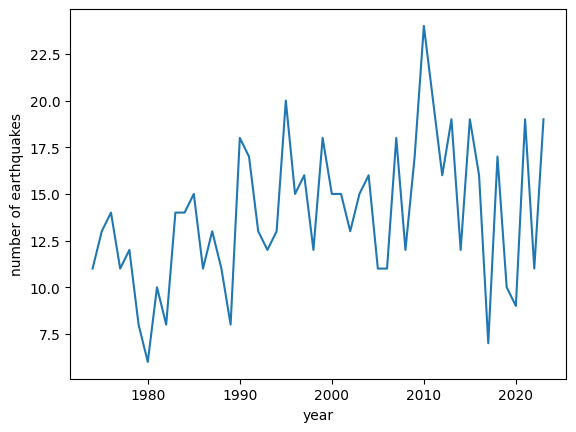

In [5]:
sns.lineplot(
    data=quake_counts,
    x='year',
    y='id'
)
plt.ylabel('number of earthquakes')
plt.savefig(os.path.join(out_dir, "quake_counts.pdf"), bbox_inches='tight')

Note: `sp.stats.gamma.pdf()` takes parameter `a`, the shape paramter, and scale, which is `1 / beta`. 

In [6]:
# possible hyperparameters

Y = quake_counts['id']

alpha = np.round(np.mean(Y))
beta = np.round(np.std(Y))

print(f'alpha = {alpha}; beta = {beta}')

alpha = 14.0; beta = 4.0


## 1.2

In [7]:
def exact_posterior(Y, alpha, beta):

    N = len(Y)

    # define closed-form posterior
    a = np.sum(Y) + alpha
    scale = 1 / (N + beta)
    
    return sps.gamma(a, scale=scale)

posterior = exact_posterior(Y, alpha, beta)

# plt.hist(exact_samples, label=r'$\lambda$')
# plt.hist(Y, label= "Y", histtype='step', density=True)
# plt.legend()

## 1.3

Well this ain't workin'....

In [8]:
def grid_approx_posterior(Y: pd.Series, alpha=14, beta=4):
   # define a grid of possible values for lambda
   # grid_lambda = np.linspace(11, 15, num=5000)

   # construct distribution for lambda using gamma prior
   a = alpha
   scale = 1 / beta

   prior = sps.gamma(a, scale=scale).logpdf(grid_lambda)
   
   likelihoods = [sps.poisson(mu = grid_lambda).logpmf(y) for y in Y]
   likelihood = np.sum(np.vstack(likelihoods), axis=0)
   
   posterior = np.exp(likelihood + prior)
   normalized = posterior / sum(posterior)

   return normalized / sum(normalized)

grid_lambda = np.linspace(10, 15, num=100)
grid_posterior = grid_approx_posterior(Y, alpha, beta)

# need to normalize twice because of floating point precision
grid_samples = np.random.choice(grid_lambda, 
                                 size=5000, 
                                 p=grid_posterior/np.sum(grid_posterior))


## 1.4

note: 

`conda uninstall clang` is needed to force cmdstan to use system compiler

pystan didn't work

In [10]:
# install_cmdstan(verbose=True)

In [11]:
poisson_model = """
data {
    int<lower=0> N;
    array[N] int<lower=0> y;
}

parameters {
    real<lower=0> lambda;
}

model {
    lambda ~ gamma(14, 4);
    y ~ poisson(lambda);
}
"""

srcpath = "../../src/"
fname = "poisson.stan"
fpath = os.path.join(srcpath, fname)
with open(fpath, "w") as stanfile:
    stanfile.write(poisson_model)

In [12]:
model = CmdStanModel(stan_file=fpath)

DEBUG:cmdstanpy:Removing /Users/tony/Documents/phd/courses/bayes/uvmbayes/src/poisson
08:33:21 - cmdstanpy - INFO - compiling stan file /Users/tony/Documents/phd/courses/bayes/uvmbayes/src/poisson.stan to exe file /Users/tony/Documents/phd/courses/bayes/uvmbayes/src/poisson
INFO:cmdstanpy:compiling stan file /Users/tony/Documents/phd/courses/bayes/uvmbayes/src/poisson.stan to exe file /Users/tony/Documents/phd/courses/bayes/uvmbayes/src/poisson
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=poisson.stan /Users/tony/Documents/phd/courses/bayes/uvmbayes/src/poisson
cwd: /Users/tony/.cmdstan/cmdstan-2.35.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=poisson.stan --o=/Users/tony/Documents/phd/courses/bayes/uvmbayes/src/poisson.hpp /Users/tony/Documents/phd/courses/bayes/uvmbayes/src/poisson.stan

--- Compiling C++ code ---
clang++ -std=c++17 -Wno-unknown-warning-option -Wno-tautological-compare -Wno-sign-compare -D_REENTR

In [13]:
data = {
    "N": len(Y),
    'y': Y
}
model_fit = model.sample(data=data, iter_sampling=5000)

DEBUG:cmdstanpy:cmd: /Users/tony/Documents/phd/courses/bayes/uvmbayes/src/poisson info
cwd: None
DEBUG:cmdstanpy:input tempfile: /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/tmp6phmrjft/5kgomuog.json
08:33:26 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/Users/tony/Documents/phd/courses/bayes/uvmbayes/src/poisson', 'id=1', 'random', 'seed=62522', 'data', 'file=/var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/tmp6phmrjft/5kgomuog.json', 'output', 'file=/var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/tmp6phmrjft/poissoniasxu2vj/poisson-20241031083326_1.csv', 'method=sample', 'num_samples=5000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/Users/tony/Documents/phd/courses/bayes/uvmbayes/src/poisson', 'id=2', 'random', 'seed=62522', 'data', 'file=/var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/tmp6phmrjft/5kgomuog.json', 'output', 'file=/var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/tmp6phmrjft/poisson

08:33:27 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/Users/tony/Documents/phd/courses/bayes/uvmbayes/src/poisson', 'id=1', 'random', 'seed=62522', 'data', 'file=/var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/tmp6phmrjft/5kgomuog.json', 'output', 'file=/var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/tmp6phmrjft/poissoniasxu2vj/poisson-20241031083326_1.csv', 'method=sample', 'num_samples=5000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/tmp6phmrjft/poissoniasxu2vj/poisson-20241031083326_1.csv
 console_msgs (if any):
	/var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/tmp6phmrjft/poissoniasxu2vj/poisson-20241031083326_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
 

In [14]:
model_fit.summary()

DEBUG:cmdstanpy:cmd: /Users/tony/.cmdstan/cmdstan-2.35.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/tmp6phmrjft/stansummary-poisson-4xewgjzo.csv /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/tmp6phmrjft/poissoniasxu2vj/poisson-20241031083326_1.csv /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/tmp6phmrjft/poissoniasxu2vj/poisson-20241031083326_2.csv /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/tmp6phmrjft/poissoniasxu2vj/poisson-20241031083326_3.csv /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/tmp6phmrjft/poissoniasxu2vj/poisson-20241031083326_4.csv
cwd: None


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,1113.510,0.006919,0.696553,1112.0900,1113.7800,1114.0100,10134.90,50929.3,1.00071
lambda,13.103,0.005559,0.491970,12.2942,13.1036,13.9155,7833.32,39363.4,1.00116


array([[<Axes: title={'center': 'lambda'}>,
        <Axes: title={'center': 'lambda'}>]], dtype=object)

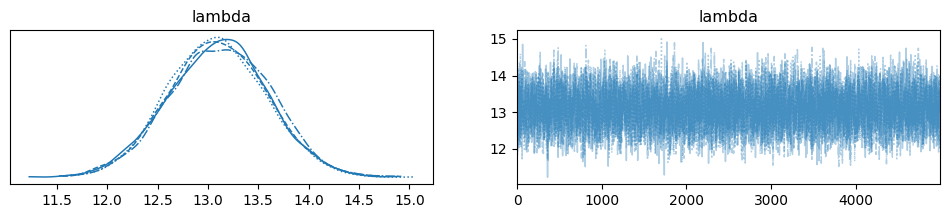

In [17]:
idata = az.from_cmdstanpy(model_fit)
az.plot_trace(idata)

## 1.5

{'Exact Samples': 'Exact Samples; post. mean = 13.11', 'Grid Approx. Samples': 'Grid Approx. Samples; post. mean = 13.12', 'HMC Samples': 'HMC Samples; post. mean = 13.10'}


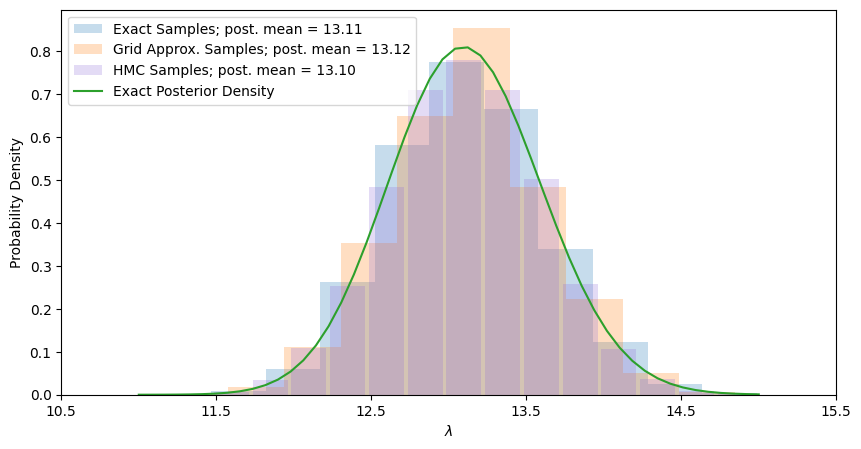

In [ ]:
def get_posterior_means(*arrays):
    means = {}
    labels = ['Exact Samples', 'Grid Approx. Samples', 'HMC Samples']

    for array, label in zip(arrays, labels):
        means[label] = f'{label}; post. mean = {np.mean(array):.2f}'

    return means

def make_comparison_plot(posterior, grid_samples, idata):

    SAMPLES = 5000

    lambda_space = np.linspace(11, 15)
    exact_posterior_density = posterior.pdf(lambda_space)
    exact_samples = posterior.rvs(SAMPLES)

    post_means = get_posterior_means(exact_samples, 
                                     grid_samples, 
                                     np.array(idata.posterior['lambda']).flatten())
    print(post_means)

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.hist(exact_samples, 
            label=post_means['Exact Samples'],
            density=True,
            alpha = 0.25)
    ax.hist(grid_samples,
            label = post_means["Grid Approx. Samples"],
            density=True,
            alpha = 0.25)
    az.plot_dist(
        idata.posterior['lambda'],
        kind='hist',
        color='mediumpurple',
        ax=ax,
        hist_kwargs = {'alpha': 0.25,
                    'label': post_means['HMC Samples']})

    ax.plot(
        lambda_space,
        exact_posterior_density,
        label="Exact Posterior Density"
    )
    
    xticks = np.arange(10.5, 16)
    plt.xticks(xticks)
    
    plt.legend()
    plt.xlabel(r'$\lambda$')
    plt.ylabel('Probability Density')

make_comparison_plot(posterior, grid_samples, idata)
plt.savefig(os.path.join(out_dir, "sample_comparison.pdf"))
